# Install required libraries


In [1]:
!pip install scanpy
!pip install optuna
!pip install igraph

### Load required packages

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import os
import sklearn
import optuna
sc.settings.verbosity = 1
print(f'sklearn_version:{sklearn.__version__}')

sklearn_version:1.5.2


In [3]:
dataset_type = "cancer" # neuro,cancer
dataset_folder = os.path.join(os.getcwd(),"data")
dataset_path  = os.path.join(dataset_folder,f'{dataset_type}.h5ad')
dataset_subpath = os.path.join(dataset_folder,f'{dataset_type}_hvg.h5ad')
dataset_pandas_path = os.path.join(dataset_folder,f'{dataset_type}_hvg.csv')
dataset_preaggregated_path = os.path.join(dataset_folder,f'{dataset_type}_preaggregated_.csv')
dataset_aggregated_path = os.path.join(dataset_folder,f'{dataset_type}_aggregated.csv')
dataset_train_path = os.path.join(dataset_folder,f'train_{dataset_type}.csv')
dataset_test_path = os.path.join(dataset_folder,f'test_{dataset_type}.csv')
DOWNLOAD= False
RANDOM_SEED = 38
dataset_links = {"neuro": "https://datasets.cellxgene.cziscience.com/2808a16d-64c5-451b-91a5-c1a2d9f270d5.h5ad ", "cancer": "https://datasets.cellxgene.cziscience.com/76c942bd-45c3-47ec-b290-1e695ec9c177.h5ad"}
if not os.path.isdir(dataset_folder):
  print(f'creating dataset_folder={dataset_folder}')
  os.makedirs(dataset_folder,exist_ok=True)


if not os.path.isfile(dataset_path) and DOWNLOAD:
  dataset_link = dataset_links[dataset_type]
  print(f'downloading dataset from link={dataset_link}.....')
  print(f"...and saving to {dataset_path}....")
  command = f"wget {dataset_link}  -O {dataset_path}"
  print(f'running command:{command}')
  os.system(command)



### Dataset preprocessing

### Helper functions


In [4]:

def process_categorical_columns(data = None, columns=[],category='ohe'):
  """
  This function encodes columns in data to either one hot encoding or label
  encoding
  Args:
  data (pd.Dataframe): preaggregated data e.g gene_exp_df
  columns (list of str) : columns to encode
  category (str): type of encoding e.g ohe or le
  returns:
  pd.DataFrame
  """
  cols_before = set(data.columns)
  if category == 'ohe':
    data = pd.get_dummies(data, columns=columns)
  elif category == 'le':
    new_columns = [f'{column}_encoded' for column in columns]
    data[new_columns] = data[columns].apply(lambda x: pd.factorize(x)[0])
    return data,new_columns
  else:
    raise Exception(f'invalid category={category}')
  encoded_columns = list(set(data.columns).difference(cols_before))
  data[encoded_columns] = data[encoded_columns].astype(np.int64)
  return data,encoded_columns

def compute_drop_columns(data=None,columns = [],null_threshold = 0.33,n=1000):
  """
  This function drops columns that have null percentage exceeding threshod
  encoding
  Args:
  data (pd.Dataframe): preaggregated data e.g gene_exp_df
  columns (list of str) : columns to consider for drop
  null_threshold (float): nul percentage to consider when dropping column
  n (int): sample size of dataframe
  returns:
  drop_columns : list of str
  """
  drop_columns = []
  for col in columns:
    nan_count = data[col].isna().sum()
    nan_percentage = nan_count/n
    if nan_percentage > 0:
      print(f'col={col} null_perc={nan_percentage}')
    if nan_percentage > null_threshold:
      print(f'dropping col={col}')
      drop_columns.append(col)
  return drop_columns

def handle_missing_data(data=None,numerical_columns=[],categorical_columns=[]):
  """
  This function replaces Nan with mean for numerical columns
  and with mode for categorical columns
  Args:
  data (pd.Dataframe): preaggregated data e.g gene_exp_df
  numerical_columns (list of str) : numerical columns to fill with mean
  categorical_columns (list of str) : categorical columns to fill with mode
  returns:
  pd.DataFrame
  """
  for col in numerical_columns:
    m = data[col].mean()
    data[col].fillna(m,inplace=True)
  for col in categorical_columns:
    m = data[col].mode()
    data[col].fillna(m,inplace=True)
  return data

#### Subset dataset

In [5]:
LOAD_COMPLETE_DATASET = False
LOAD_PREAGGREGATED_DATASET = False  and (not LOAD_COMPLETE_DATASET)# LOAD_COMPLETE_DATASET needs to be False and False if high RAM available
LOAD_AGGREGATED_DATASET = False and (not LOAD_PREAGGREGATED_DATASET)#LOAD_PREAGGREGATED_DATASET needs to be False and True if NOT high RAM available
LOAD_TRAIN_TEST_DATASET = True and (not LOAD_AGGREGATED_DATASET) # LOAD_AGGREGATED_DATASET needs to be False and True if NOT high RAM available


In [6]:
if LOAD_COMPLETE_DATASET :
  print(f'reading complete dataset at: {dataset_path}')
  adata = sc.read_h5ad(dataset_path)
  vars = list(adata.var_names)
  non_gene_vars = [var for var in vars if 'ENSG' not in var]
  print(f'non_gene_vars={non_gene_vars}')
  #ordering of filtering matters
  #we should filter by cells and then genes
  sc.pp.filter_cells(adata, min_genes=150,inplace=True) # keep cells with gene exp in atleast 150 genes
  sc.pp.filter_genes(adata, min_cells=15,inplace=True)  # keep genes expressed in ≥15 cells
  remaining_genes = list(adata.var_names)
  filtered_genes = set(vars).difference(set(remaining_genes))
  print('filtered_genes:',len(filtered_genes))
  print('remaining_genes:',len(remaining_genes))

  #total count normalization
  sc.pp.normalize_total(adata,target_sum=1e6)
  # log scale data to ensure smoother distribution
  sc.pp.log1p(adata)

  #plot highly expressive genes
  sc.pl.highest_expr_genes(adata, n_top=50)

  #dimensionality reduction
  sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat',inplace=True)
  adata  = adata[:, adata.var['highly_variable']]

  #use pca
  sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)
  sc.pl.pca_scatter(adata, color="disease")
  sc.pl.pca_scatter(adata, color="tissue")
  sc.pl.pca_scatter(adata, color="cell_type")

  #save the smaller scanpy file with highly variable genes only (hvg)
  save_subset = True
  adata  = adata[:, adata.var['highly_variable']]
  if save_subset:
    print(f'saving dataset to dataset_subpath={dataset_subpath}')
    adata.write_h5ad(dataset_subpath)
  #specify columns for our dataset
  metadata_columns = ['donor_id']
  ohe_columns = ['sex','cell_type','tissue'] #keeping for aggregation purposes
  label_column = ['disease']
  le_columns = label_column
  categorical_columns = ohe_columns
  numerical_columns = [col for col in list(adata.var_names) if 'ENSG' in col]
  #create dataframe to facilitate modeling and analysis
  gene_expr_df = pd.DataFrame(adata.X.toarray(), index=adata.obs['donor_id'], columns= numerical_columns)
  for col in categorical_columns + label_column:
    gene_expr_df[col] = adata.obs[col].values
  print(f'saving dataset to dataset_preaggregated_path={dataset_preaggregated_path}')
  gene_expr_df.to_csv(dataset_preaggregated_path,index=True)
  print(f'saving dataset from dataset_preaggregated_path={dataset_preaggregated_path}')
  #there is a bug in scanpy so its important to load file as a csv directly from pandas
  gene_expr_df = pd.read_csv(dataset_preaggregated_path)
  num_samples = gene_expr_df.shape[0]

  drop_cols = compute_drop_columns(data=gene_expr_df,columns = numerical_columns + categorical_columns,null_threshold = 0.33,n=num_samples)
  if len(drop_cols):
    print(f"drop_cols:{drop_cols}")
    gene_expr_df.drop(drop_cols,axis=1,inplace=True)
  #aggregating dataset to reduce sparsity issue and allow for compute efficiency
  group_cols = ['donor_id','disease']
  print(f'categorical_columns:{categorical_columns} numerical_columns:{numerical_columns}')
  agg_expr_df = gene_expr_df.groupby(group_cols).mean(numerical_columns).reset_index()
  before = agg_expr_df.shape[0]
  nan_columns_agg = agg_expr_df.isna().sum()[agg_expr_df.isna().sum() > 0].index
  print(f'nan_columns:{nan_columns_agg}')
  print(f'saving aggregated dataset to {dataset_aggregated_path}')
  agg_expr_df.to_csv(dataset_aggregated_path,index=False)
  agg_expr_df
elif LOAD_PREAGGREGATED_DATASET:
  print(f'reading dataset from dataset_preaggregated_path={dataset_preaggregated_path}')
  gene_expr_df = pd.read_csv(dataset_preaggregated_path)
  metadata_columns = ['donor_id']
  ohe_columns = ['sex','cell_type','tissue'] #keeping for aggregation purposes
  label_column = ['disease']
  le_columns = label_column
  categorical_columns = ohe_columns + le_columns
  numerical_columns = [col for col in list(gene_expr_df) if 'ENSG' in col]
  num_samples = gene_expr_df.shape[0]
  drop_cols = compute_drop_columns(data=gene_expr_df,columns = numerical_columns + categorical_columns,null_threshold = 0.33,n=num_samples)
  if len(drop_cols):
    print(f"drop_cols:{drop_cols}")
    gene_expr_df.drop(drop_cols,axis=1,inplace=True)

  #aggregating dataset to reduce sparsity issue and allow for compute efficiency
  group_cols = ['donor_id','disease']
  print(f'categorical_columns:{categorical_columns} numerical_columns:{numerical_columns}')
  agg_expr_df = gene_expr_df.groupby(group_cols).mean(numerical_columns).reset_index()
  before = agg_expr_df.shape[0]
  nan_columns_agg = agg_expr_df.isna().sum()[agg_expr_df.isna().sum() > 0].index
  print(f'nan_columns:{nan_columns_agg}')
  print(f'saving aggregated dataset to {dataset_aggregated_path}')
  assert all([True if 'ENSG' in col else False for col in numerical_columns ])
  agg_expr_df.to_csv(dataset_aggregated_path,index=False)
  agg_expr_df
elif LOAD_AGGREGATED_DATASET:
  print(f'reading aggregated dataset from {dataset_aggregated_path}')
  #load aggregated dataset
  agg_expr_df = pd.read_csv(dataset_aggregated_path)
  #set dataset specific respective columns
  metadata_columns = ['donor_id']
  ohe_columns = ['sex','cell_type','tissue'] #keeping for aggregation purposes
  label_column = ['disease']
  le_columns = label_column
  categorical_columns = ohe_columns + le_columns
  #ensg are gene ids
  numerical_columns = [col for col in list(agg_expr_df) if 'ENSG' in col]
  assert all([True if 'ENSG' in col else False for col in numerical_columns ])




### Split Dataset

In [7]:
import xgboost as xgb
from sklearn.model_selection import StratifiedGroupKFold,GroupKFold,GroupShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

### Stratified split

In [8]:
if not LOAD_TRAIN_TEST_DATASET:
  print('running train/test splits...')
  ohe_columns = ['sex','cell_type','tissue'] #keeping for aggregation purposes
  if dataset_type == 'cancer':
    ignore_cols = ['cell_type','sex','tissue','development_stage']
    ohe_columns = []
    print(f'ignoring columns={ignore_cols} for {dataset_type} dataset ')
    agg_expr_df.drop(ignore_cols,axis=1,inplace=True)
    ohe_columns = list(set(ohe_columns).difference(set(ignore_cols)))
  le_columns = ['disease']
  if len(ohe_columns):
    agg_expr_df,ohe_columns = process_categorical_columns(data = agg_expr_df,columns=ohe_columns,category='ohe' )
  agg_expr_df,le_columns_new = process_categorical_columns(data = agg_expr_df,columns=le_columns,category='le' )
  categorical_columns = ohe_columns
  feature_cols = list(set(agg_expr_df.columns).intersection(set(categorical_columns + numerical_columns)))
  categorical_columns = list(set(feature_cols).difference(set(numerical_columns)))
  label_columns = ['disease','disease_encoded']
  label_column = 'disease_encoded'
  assert len(set(feature_cols).intersection(set(metadata_columns))) == 0
  assert len(feature_cols) == len(categorical_columns + numerical_columns)
  print(f'categorical_cols:{len(categorical_columns)}')
  print(f'numerical_cols:{len(numerical_columns)}')
  print(f'feature_cols:{len(feature_cols)}')
  print(f'le_cols:{len(le_columns)}')
  print(f'le_cols_new:{len(le_columns_new)}')

  agg_expr_df[feature_cols + label_columns]
  # Use StratifiedGroupKFold for donor-aware stratified splitting
  splitter = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
  label_column = 'disease_encoded'
  metadata_column = 'donor_id'
  group_col = metadata_column
  y = agg_expr_df[label_column]
  groups = agg_expr_df[metadata_column]

  # Grab first split only
  for train_idx, test_idx in splitter.split(agg_expr_df, agg_expr_df[label_column], groups):
      df_train = agg_expr_df.iloc[train_idx].copy()
      df_test = agg_expr_df.iloc[test_idx].copy()
      break

  # Sanity checks
  assert not set(df_train[group_col]) & set(df_test[group_col]), "Donor overlap detected!"

  # Check label distribution
  train_dist = df_train[label_column].value_counts(normalize=True).rename("train %")
  test_dist = df_test[label_column].value_counts(normalize=True).rename("test %")
  print("Disease label proportions (train vs test):")
  print(pd.concat([train_dist, test_dist], axis=1))
  print("Train shape:", df_train.shape)
  print("Test shape:", df_test.shape)


  # -------------------------
  # STANDARDIZATION (Z-scoring only gene expression features)
  # -------------------------

  # Compute mean/std from training data
  mu = df_train[numerical_columns].mean()
  sd = df_train[numerical_columns].std().replace(0, 1)

  # Apply standardization
  df_train[numerical_columns] = (df_train[numerical_columns] - mu) / sd
  df_test[numerical_columns] = (df_test[numerical_columns] - mu) / sd


  # Save standardized splits
  print(f'saving train to {dataset_train_path}')
  print(f'saving test to {dataset_test_path}')
  df_train.to_csv(dataset_train_path, index=False)
  df_test.to_csv(dataset_test_path, index=False)
  print("Standardized gene expression features saved.")
else:
  # Load standardized splits
  print(f'Loading train from {dataset_train_path}')
  print(f'Loading test from {dataset_test_path}')



  df_train = pd.read_csv(dataset_train_path)
  df_test = pd.read_csv(dataset_test_path)


  train_groups = df_train.donor_id.unique()
  test_groups = df_test.donor_id.unique()

  assert len(set(df_train.columns).intersection(set(df_test.columns))) == len(df_train.columns)
  #need to ohe train+test combined
  agg_expr_df = pd.concat([df_train,df_test],axis=0)
  if dataset_type == 'cancer':
    ignore_cols = ['cell_type','sex','tissue','development_stage']
    ohe_columns = []
    print(f'ignoring columns={ignore_cols} for {dataset_type} dataset ')
    agg_expr_df.drop(ignore_cols,axis=1,inplace=True)
  else:
    ohe_columns = ['sex','cell_type','tissue']

  le_columns = ['disease']
  if len(ohe_columns):
    agg_expr_df,ohe_columns = process_categorical_columns(data = agg_expr_df,columns=ohe_columns,category='ohe' )
  agg_expr_df,le_columns_new = process_categorical_columns(data = agg_expr_df,columns=le_columns,category='le' )
  categorical_columns = ohe_columns
  numerical_columns = [col for col in df_train.columns if 'ENSG' in col]
  label_column = ['disease_encoded']
  label_columns = ['disease','disease_encoded']
  metadata_columns = ['donor_id']
  feature_cols = list(set(agg_expr_df.columns).intersection(set(categorical_columns + numerical_columns)))
  categorical_columns = list(set(feature_cols).difference(set(numerical_columns)))
  label_columns = ['disease','disease_encoded']
  label_column = 'disease_encoded'
  assert len(set(feature_cols).intersection(set(metadata_columns))) == 0
  assert len(feature_cols) == len(categorical_columns + numerical_columns)
  df_train , df_test = agg_expr_df[agg_expr_df.donor_id.isin(train_groups)],agg_expr_df[agg_expr_df.donor_id.isin(test_groups)]



train_groups = df_train['donor_id']
X_train,X_test = df_train[feature_cols],df_test[feature_cols]
y_train,y_test = df_train[label_columns],df_test[label_columns]


print('train:',X_train.shape,y_train.shape)
print('test:',X_test.shape,y_test.shape)



Loading train from /content/data/train_cancer.csv
Loading test from /content/data/test_cancer.csv
ignoring columns=['cell_type', 'sex', 'tissue', 'development_stage'] for cancer dataset 
train: (839, 1500) (839, 2)
test: (227, 1500) (227, 2)


In [9]:
num_classes = len(y_train[label_column].unique())
num_features = len(feature_cols)
print(f'num_featiures={num_features}')
print(f'num_classes={num_classes}')
assert len(feature_cols) == X_train.shape[1]

num_featiures=1500
num_classes=8


In [10]:
if len(list(set(X_train.columns).intersection(set(metadata_columns)))):
  print(f'dropping columns={metadata_columns} from train')
  X_train.drop(metadata_columns,axis=1,inplace=True)
  print(X_train.shape,y_train.shape)

if len(list(set(X_test.columns).intersection(set(metadata_columns)))):
  print(f'dropping columns={metadata_columns} from test')
  X_test.drop(metadata_columns,axis=1,inplace=True)
  print(X_test.shape,y_test.shape)

### Model training with hyperparameter tuning

### Initializing xgboost and parameter spaces

## Xgboost

In [11]:
import xgboost as xgb


### Parameters

In [12]:
if dataset_type == 'cancer':
  xgboost_params = {
      'n_estimators': [20,100],
      'booster':['gbtree','dart'],
      'max_depth': [3,12],
      'max_leaves':  [4,12],
      'learning_rate':[0.003,0.03],
      'grow_policy': ['depthwise','lossguide'],
      'gamma': [0.0,5.0],
      'reg_alpha':[0.1,1.0],
      'reg_lambda':[0.1,1.0],
  }
else:
  xgboost_params = {
      'n_estimators': [20,30],
      'booster':['gbtree','dart'],
      'max_depth': [3,12],
      'max_leaves':  [4,8],
      'learning_rate':[0.003,0.03],
      'grow_policy': ['depthwise','lossguide'],
      'gamma': [1.0,10.0],
      'reg_alpha':[1,1.0],
      'reg_lambda':[1,1.0],
  }


In [13]:
### SearchSpace
search_space = {
    'xgboost': xgboost_params,
}

### SearchSpace

Here we define a dictionary specifying the lower,upperbounds of each model's parameters.

We do a bayesian optimization. To optimize for compute, we select each model probabilistically during each trial rather than optimize each model separately which can be very expensive

This is better strategy in practice due to efficiency

In [14]:
import optuna
import numpy as np
import math
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from joblib import Parallel, delayed
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc,roc_auc_score,RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns


step = 0
metric_list = []
def objective_function(trial,X,y,groups,label_column,ALLOWED_MODELS):
  global step
  global metric_list
  global num_classes

  # ALLOWED_MODELS = list(search_space.keys())
  model_name = trial.suggest_categorical('model_name',ALLOWED_MODELS)
  # model_name = 'xgboost'
  model_params = search_space[model_name]
  model_params_dict = {}
  # print(f'model_name={model_name}')
  for param,param_bounds in model_params.items():
    # print(f'param={param} param_bounds={param_bounds}')
    if isinstance(param_bounds[0],int):
      if param == 'n_estimators':
        param_value = int(trial.suggest_loguniform(param,param_bounds[0],param_bounds[1]))
      else:
        param_value = trial.suggest_int(param,param_bounds[0],param_bounds[1])
    elif isinstance(param_bounds[0],float):
      param_value = trial.suggest_float(param,param_bounds[0],param_bounds[1])
    elif isinstance(param_bounds[0],str):
      param_value  = trial.suggest_categorical(param,param_bounds)
    model_params_dict[param] = param_value

  print(f'model_params:{model_params_dict}')
  if model_name == 'xgboost':
    if model_params_dict['grow_policy'] == 'depthwise':
      del model_params_dict['max_leaves']
    elif model_params_dict['grow_policy'] == 'lossguide':
      del model_params_dict['max_depth']

    if num_classes == 2:
      model_params_dict['objective'] = 'binary:logistic'
    elif num_classes > 2:
      model_params_dict['objective'] = 'multi:softmax'
    model_params_dict['verbosity'] = 0
    model_params_dict['random_state'] = RANDOM_SEED
    model = xgb.XGBClassifier(**model_params_dict)



  sgkf = StratifiedGroupKFold(n_splits=3)
  train_scores = []
  test_scores = []
  for i, (train_index, test_index) in enumerate(sgkf.split(X, y[label_column], groups)):
    # print(f"Fold {i}:")
    if model_name == 'xgboost':
      model.fit(X.iloc[train_index], y.iloc[train_index][label_column],verbose=False)
      y_pred_train = model.predict(X.iloc[train_index])
      y_pred_test = model.predict(X.iloc[test_index])
      train_score = accuracy_score(y.iloc[train_index][label_column], y_pred_train)
      test_score = accuracy_score(y.iloc[test_index][label_column], y_pred_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
  step +=1
  mean_score = np.mean(test_scores)
  metric_dict = {'model': model_name,'score': mean_score,'step':step}
  metric_dict.update(model_params_dict)
  metric_list.append(metric_dict)
  trial.report(-mean_score, step)
  if trial.should_prune():
      raise optuna.TrialPruned()
  return -mean_score

In [15]:
study = optuna.create_study(direction="minimize",study_name="mls")
ALLOWED_MODELS = ['xgboost']
recompute_best_parameters  = True
if recompute_best_parameters:
  study.optimize(lambda trial: objective_function(trial, X_train,y_train,train_groups,label_column,ALLOWED_MODELS),n_trials=10,n_jobs=-1)
  metric_df = pd.DataFrame(metric_list)
  metric_path = os.path.join(os.getcwd(),"data",f"{dataset_type}_metrics.csv")
  print(f'saving metrics to {metric_path}')
  metric_df.to_csv(metric_path)
  max_score = metric_df.score.max()
  param_cols = list(set(metric_df.columns).difference(['model','score','step']))
  best_params = metric_df[metric_df.score == max_score][param_cols]
  best_params_dict = {}
  for param in param_cols:
    value = best_params[param].values[0]
    print(f'param={param} value:{value}')
    if not isinstance(value,str):
      if math.isnan(value): #some parameters are not used alongside certain parameters

        continue
    if param == 'verbosity':
      value = 0
    elif param  in ['n_estimators','max_depth','max_leaves']:
      value = int(value)

    best_params_dict[param] = value

  print(f'best_params={best_params_dict}')

else:
  if dataset_type == 'neuro':
    # neuro:
    best_params_dict={'grow_policy': 'lossguide', 'reg_alpha': np.int64(1), 'n_estimators': 29, 'max_leaves': 6, 'objective': 'multi:softmax', 'gamma': np.float64(6.741859995297201), 'verbosity': 0, 'reg_lambda': np.int64(1), 'learning_rate': np.float64(0.02208961449305022), 'booster': 'gbtree'}
  else:
  # cancer:
    best_params_dict ={'grow_policy': 'lossguide', 'verbosity': 0, 'reg_lambda': np.float64(0.15396351269925057), 'n_estimators': 27, 'learning_rate': np.float64(0.00476264983945982), 'booster': 'dart', 'reg_alpha': np.float64(0.46153890298839073), 'objective': 'multi:softmax', 'gamma': np.float64(4.257076185241912), 'max_leaves': 10}




[I 2025-05-01 00:08:19,495] A new study created in memory with name: mls


model_params:{'n_estimators': 78, 'booster': 'dart', 'max_depth': 5, 'max_leaves': 12, 'learning_rate': 0.01051140577681311, 'grow_policy': 'lossguide', 'gamma': 3.4756706656632907, 'reg_alpha': 0.9251809070367749, 'reg_lambda': 0.22347862944016317}
model_params:{'n_estimators': 39, 'booster': 'dart', 'max_depth': 3, 'max_leaves': 6, 'learning_rate': 0.021420765236184774, 'grow_policy': 'lossguide', 'gamma': 3.88203810210054, 'reg_alpha': 0.3859294341701963, 'reg_lambda': 0.3456054196777131}
model_params:{'n_estimators': 62, 'booster': 'gbtree', 'max_depth': 4, 'max_leaves': 5, 'learning_rate': 0.026551832071135307, 'grow_policy': 'depthwise', 'gamma': 3.242120940574893, 'reg_alpha': 0.9446355522347973, 'reg_lambda': 0.9222700417683166}
model_params:{'n_estimators': 99, 'booster': 'gbtree', 'max_depth': 3, 'max_leaves': 10, 'learning_rate': 0.004955808242080509, 'grow_policy': 'depthwise', 'gamma': 1.3459644234862251, 'reg_alpha': 0.72910043352831, 'reg_lambda': 0.14467000021783133}
mo

<ipython-input-14-7bcdb2fc070c>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_value = int(trial.suggest_loguniform(param,param_bounds[0],param_bounds[1]))
<ipython-input-14-7bcdb2fc070c>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_value = int(trial.suggest_loguniform(param,param_bounds[0],param_bounds[1]))
<ipython-input-14-7bcdb2fc070c>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_value = int(trial.suggest_loguniform(param,param_bounds[0],param_bounds[1]))
<ipython-input-14-7bcd

model_params:{'n_estimators': 45, 'booster': 'gbtree', 'max_depth': 5, 'max_leaves': 12, 'learning_rate': 0.027157970948505333, 'grow_policy': 'lossguide', 'gamma': 4.8604057551127395, 'reg_alpha': 0.45018224237892035, 'reg_lambda': 0.18609402031078542}


[I 2025-05-01 00:10:30,528] Trial 5 finished with value: -0.7376661034116774 and parameters: {'model_name': 'xgboost', 'n_estimators': 41.66977812956534, 'booster': 'gbtree', 'max_depth': 5, 'max_leaves': 10, 'learning_rate': 0.008585231910312189, 'grow_policy': 'depthwise', 'gamma': 3.689151386977022, 'reg_alpha': 0.4827592287331175, 'reg_lambda': 0.36610965607976964}. Best is trial 5 with value: -0.7376661034116774.
<ipython-input-14-7bcdb2fc070c>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_value = int(trial.suggest_loguniform(param,param_bounds[0],param_bounds[1]))


model_params:{'n_estimators': 27, 'booster': 'dart', 'max_depth': 3, 'max_leaves': 12, 'learning_rate': 0.016615696052725087, 'grow_policy': 'lossguide', 'gamma': 0.7315265366767798, 'reg_alpha': 0.5177722154281355, 'reg_lambda': 0.3816507363107724}


[I 2025-05-01 00:10:34,983] Trial 7 finished with value: -0.766342133215223 and parameters: {'model_name': 'xgboost', 'n_estimators': 45.84118294933141, 'booster': 'gbtree', 'max_depth': 5, 'max_leaves': 12, 'learning_rate': 0.027157970948505333, 'grow_policy': 'lossguide', 'gamma': 4.8604057551127395, 'reg_alpha': 0.45018224237892035, 'reg_lambda': 0.18609402031078542}. Best is trial 7 with value: -0.766342133215223.
<ipython-input-14-7bcdb2fc070c>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  param_value = int(trial.suggest_loguniform(param,param_bounds[0],param_bounds[1]))


model_params:{'n_estimators': 50, 'booster': 'gbtree', 'max_depth': 4, 'max_leaves': 9, 'learning_rate': 0.00787032048375819, 'grow_policy': 'depthwise', 'gamma': 1.7407044633178814, 'reg_alpha': 0.7787315915157059, 'reg_lambda': 0.7725422554305378}


[I 2025-05-01 00:11:09,244] Trial 2 finished with value: -0.7687578641679281 and parameters: {'model_name': 'xgboost', 'n_estimators': 62.50569637856212, 'booster': 'gbtree', 'max_depth': 4, 'max_leaves': 5, 'learning_rate': 0.026551832071135307, 'grow_policy': 'depthwise', 'gamma': 3.242120940574893, 'reg_alpha': 0.9446355522347973, 'reg_lambda': 0.9222700417683166}. Best is trial 2 with value: -0.7687578641679281.
[I 2025-05-01 00:11:13,756] Trial 4 finished with value: -0.7687492378637387 and parameters: {'model_name': 'xgboost', 'n_estimators': 67.41722596717766, 'booster': 'gbtree', 'max_depth': 10, 'max_leaves': 5, 'learning_rate': 0.022428487709939486, 'grow_policy': 'lossguide', 'gamma': 1.8475849821176622, 'reg_alpha': 0.9643605968795771, 'reg_lambda': 0.7941941300066677}. Best is trial 2 with value: -0.7687578641679281.
[I 2025-05-01 00:11:59,754] Trial 3 finished with value: -0.7376578428871711 and parameters: {'model_name': 'xgboost', 'n_estimators': 99.10108958088622, 'boo

saving metrics to /content/data/cancer_metrics.csv
param=booster value:gbtree
param=learning_rate value:0.004955808242080509
param=reg_lambda value:0.14467000021783133
param=reg_alpha value:0.72910043352831
param=max_leaves value:nan
param=max_depth value:3.0
param=objective value:multi:softmax
param=random_state value:38
param=gamma value:1.3459644234862251
param=n_estimators value:99
param=verbosity value:0
param=grow_policy value:depthwise
best_params={'booster': 'gbtree', 'learning_rate': np.float64(0.004955808242080509), 'reg_lambda': np.float64(0.14467000021783133), 'reg_alpha': np.float64(0.72910043352831), 'max_depth': 3, 'objective': 'multi:softmax', 'random_state': np.int64(38), 'gamma': np.float64(1.3459644234862251), 'n_estimators': 99, 'verbosity': 0, 'grow_policy': 'depthwise'}


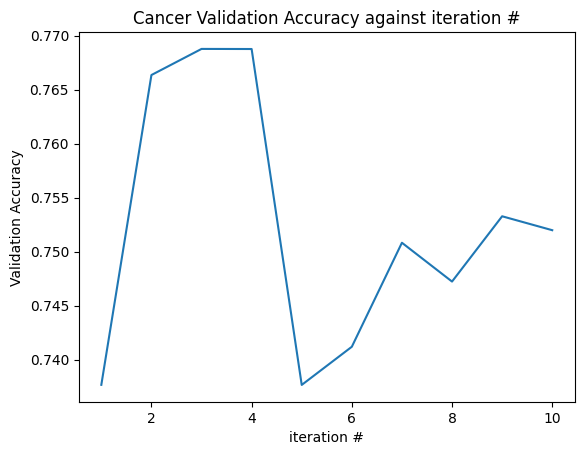

In [24]:
plt.plot(metric_df['step'],metric_df['score'])
plt.xlabel('iteration #')
plt.ylabel("Validation Accuracy")
plt.title('Cancer Validation Accuracy against iteration #')
plt.show()

### Best model

In [17]:
best_params_dict['random_state'] = RANDOM_SEED
final_model =  xgb.XGBClassifier(**best_params_dict)
final_model = final_model.fit(X_train,y_train['disease_encoded'])
label_column1 = 'disease_encoded'
label_column2 = 'disease'
y_pred = final_model.predict(X_test)
print("Final Test Accuracy:", accuracy_score(y_test[label_column1], y_pred))


Final Test Accuracy: 0.7929515418502202


### Evaluation

In [18]:
#create a mapping to reverse decode integer labels back to strings
mapping = {}
reverse_mapping = {}
for row_index,row in agg_expr_df[['disease_encoded','disease']].iterrows():
  mapping[int(row['disease_encoded'])] = row['disease']
  reverse_mapping[row['disease']] = int(row['disease_encoded'])
print(f'mapping:{mapping}')

mapping:{0: 'breast cancer', 1: 'normal', 2: 'uveal melanoma', 3: 'ovarian cancer', 4: 'melanoma', 5: 'liver cancer', 6: 'colorectal cancer', 7: 'lung cancer'}


In [19]:
### metrics

### Metrics

In [20]:
print("Final Test Accuracy:", accuracy_score(y_test[label_column1], y_pred))

# Perform Final Test Evaluation on the test dataset
y_pred_mapped = [mapping[yp] for yp in y_pred]


# Define label order: put "Normal" first, then the rest alphabetically
all_labels = sorted(agg_expr_df[label_column2].unique())
labels = ["normal"] + [lbl for lbl in all_labels if lbl != "normal"]

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test[label_column2], y_pred_mapped, labels=labels))

Final Test Accuracy: 0.7929515418502202

Classification Report:
                   precision    recall  f1-score   support

           normal       0.69      0.84      0.76        45
    breast cancer       0.68      0.93      0.78        29
colorectal cancer       0.86      0.67      0.75         9
     liver cancer       0.62      0.65      0.64        23
      lung cancer       0.97      0.68      0.80        44
         melanoma       1.00      1.00      1.00        44
   ovarian cancer       0.62      0.80      0.70        10
   uveal melanoma       0.92      0.52      0.67        23

         accuracy                           0.79       227
        macro avg       0.79      0.76      0.76       227
     weighted avg       0.82      0.79      0.79       227



### Confusion Matrix

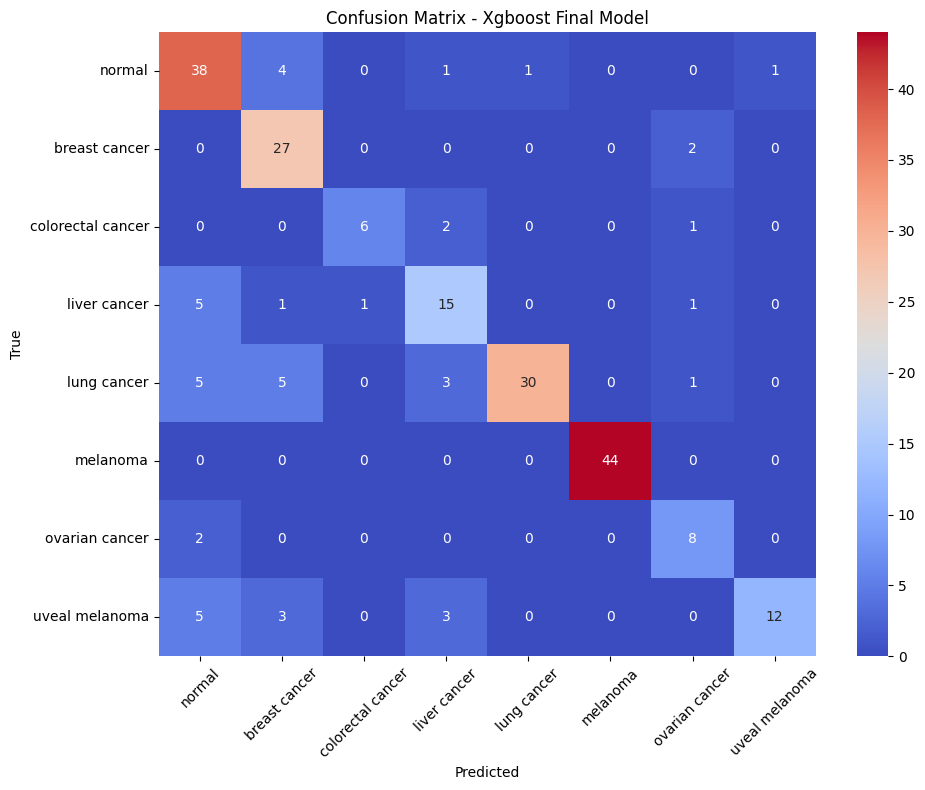

In [21]:
# ANALYSIS 1: Confusion Matrix
''' A confusion matrix provides a detailed breakdown of correct and incorrect predictions by showing how often predicted labels match the true labels for each class. It helps identify specific classes that are miscalssified or overrepresented.'''
# Compute confusion matrix with this specific label order
y_pred_string = [mapping[yp] for yp in y_pred]
y_test_string = [mapping[yp] for yp in y_test[label_column1]]

cm = confusion_matrix(y_test_string, y_pred_string, labels=labels)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="coolwarm",
    xticklabels=labels,
    yticklabels=labels
)
plt.title("Confusion Matrix - Xgboost Final Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Roc

\ ROC-AUC (macro-average): 0.5655


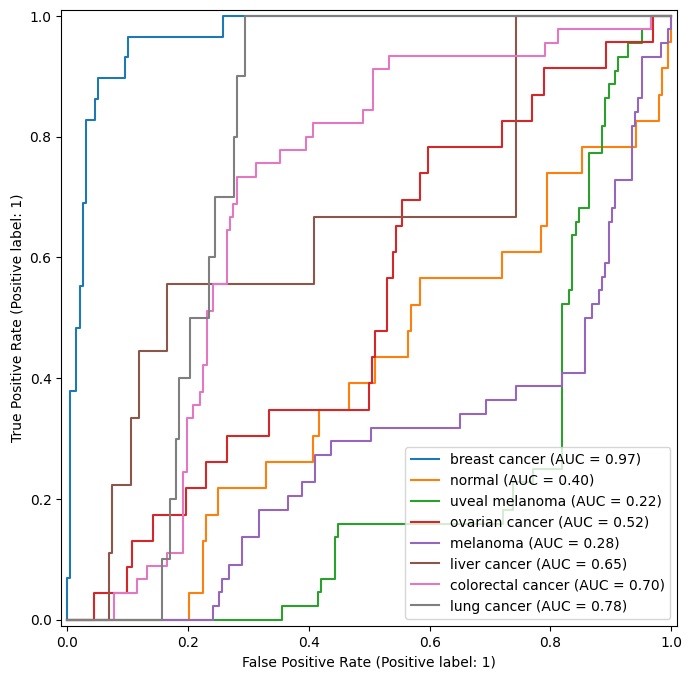

In [22]:
final_prob = final_model.predict_proba(X_test)
# classes1 = agg_expr_df[label_column1].unique()
classes2 = y_test[label_column1].unique()
y_test_bin = label_binarize(y_test[label_column1], classes=classes2)
auc = roc_auc_score(y_test_bin, final_prob, average="macro", multi_class="ovr")
print(f"\ ROC-AUC (macro-average): {auc:.4f}")

fig, ax = plt.subplots(figsize=(10, 8))
for i in range(num_classes):
    class_name = mapping[i]
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i],
        final_prob[:, i],
        name=f"{class_name}",
        ax=ax
    )


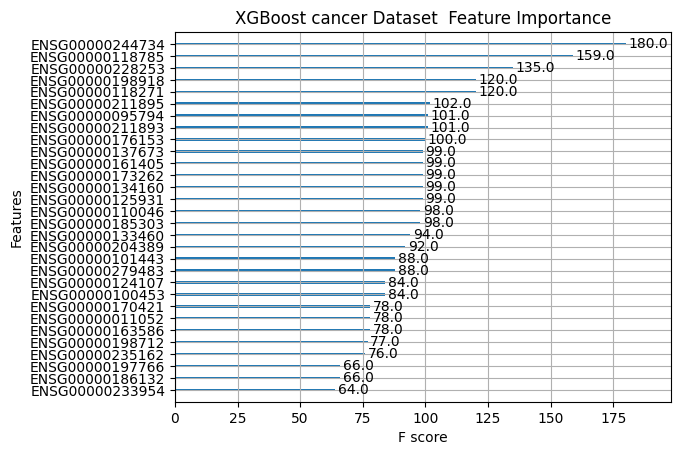

In [23]:
xgb.plot_importance(final_model,max_num_features=30)
plt.title(f"XGBoost {dataset_type} Dataset  Feature Importance")
plt.show()